# Pipeline draft

In [1]:
import torch
import numpy as np
from omegaconf import OmegaConf
from functools import partial
import gymnasium as gym
import matplotlib.pyplot as plt

import bbrl_utils
from bbrl_utils.notebook import setup_tensorboard
from bbrl.stats import WelchTTest
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl.agents.gymnasium import ParallelGymAgent, make_env
from bbrl.workspace import Workspace
from bbrl.utils.replay_buffer import ReplayBuffer

from pmind_utils import (
    DQN,
    DDPG,
    TD3,
    dqn_compute_critic_loss,
    ddqn_compute_critic_loss,
    run_dqn,
    run_ddpg,
    run_td3,
    run_td3_offline,
    get_gym_agent,
    get_workspace,
    mix_transitions,
    test_rb_compositions
)

bbrl_utils.setup()

%load_ext autoreload
%autoreload 2

/Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401
Using Python 3.10.18 environment at: /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv


Load all configurations:

In [2]:
cfg = OmegaConf.load("config.yaml")

In [3]:
setup_tensorboard("./outputs/tblogs")

Reusing TensorBoard on port 6007 (pid 83092), started 0:03:12 ago. (Use '!kill 83092' to kill it.)

## Best policy:

Get the best policy (to eventually exploit)

In [4]:
cfg_td3_best = OmegaConf.create(cfg.bbrl_examples.td3)

# accelerate for the sake of test:
cfg_td3_best.algorithm.max_epochs = 11_000
cfg_td3_best.algorithm.learning_starts = 1000

td3 = TD3(cfg_td3_best)
run_td3(td3)
td3.visualize_best()

Matplotlib backend: inline


  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in folder outputs/CartPoleContinuous-v1/td3-S1_20260208-124646/best_agent


objc[84676]: Class SDLApplication is implemented in both /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/cv2/.dylibs/libSDL2-2.0.0.dylib (0x12f858890) and /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x1351312c8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[84676]: Class SDLAppDelegate is implemented in both /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/cv2/.dylibs/libSDL2-2.0.0.dylib (0x12f8588e0) and /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x135131318). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[84676]: Class SDLTranslatorResponder is implemented in both /Users/vlad/Documents/U

moviepy is not installed, skipping video display


In [5]:
best_policy_agent = td3.best_policy

In [6]:
gym_agent = get_gym_agent('CartPoleContinuous-v1', num_envs=10, seed=42)
workspace_best = get_workspace(best_policy_agent ,gym_agent, epoch_size=10_000)
print(workspace_best)

Workspace:
	env/env_obs: time_size = 10000, batch_size = 10
	env/terminated: time_size = 10000, batch_size = 10
	env/truncated: time_size = 10000, batch_size = 10
	env/done: time_size = 10000, batch_size = 10
	env/reward: time_size = 10000, batch_size = 10
	env/cumulated_reward: time_size = 10000, batch_size = 10
	env/timestep: time_size = 10000, batch_size = 10
	action: time_size = 10000, batch_size = 10


## Uniform policy:

In [7]:
class UniformAgent(Agent):
    '''Agent that explores uniformly a given environment'''

    # TODO: for now it just does a random walk,
    #   need to do jumps instead - random actions in random states
    # I think need to modify ParallelGymAgent._reset() method
    def __init__(self, env_name):
        super().__init__()
        self.env = gym.make(env_name) 

    def forward(self, t: int):
        """An Agent can use self.workspace"""
        # obs = self.get(("env/env_obs", t))
        n_env = self.workspace.batch_size()
        action = torch.tensor([self.env.action_space.sample() for _ in range(n_env) ], dtype=torch.float32)
        self.set(("action", t), action)

In [8]:
workspace_unif = get_workspace(UniformAgent('CartPoleContinuous-v1'), gym_agent, epoch_size=10_000)
print(workspace_unif)

/var/folders/hr/c9xk46kd0t3c2nlgs6zkg2_h0000gn/T/ipykernel_84676/2912439160.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  action = torch.tensor([self.env.action_space.sample() for _ in range(n_env) ], dtype=torch.float32)


Workspace:
	env/env_obs: time_size = 10000, batch_size = 10
	env/terminated: time_size = 10000, batch_size = 10
	env/truncated: time_size = 10000, batch_size = 10
	env/done: time_size = 10000, batch_size = 10
	env/reward: time_size = 10000, batch_size = 10
	env/cumulated_reward: time_size = 10000, batch_size = 10
	env/timestep: time_size = 10000, batch_size = 10
	action: time_size = 10000, batch_size = 10


In [9]:
# Poking around with the idea: may be it's easier to implement those 
# random jumps as episodes of length 2?
# for k in range(gym_agent.num_envs):
#     env = gym_agent.envs[k]
#     env.reset()
#     env.state = env.unwrapped.state = env.observation_space.sample()
# gym_agent = get_gym_agent('CartPoleContinuous-v1', num_envs=3, seed=42)
# t_agents = TemporalAgent(Agents(gym_agent,UniformAgent('CartPoleContinuous-v1')))
# workspace = Workspace()
# t_agents(workspace, t=1,n_steps=2)
# workspace_unif.get_transitions()["env/reward"]

## Mix transitions in a buffer

In [10]:
rb_mixed = mix_transitions(workspace_unif,
                           workspace_best,
                           buffer_size=10_000, 
                           proportion=1)

# Offline learning on mixed replay buffer

In [11]:
cfg_td3_offline = OmegaConf.create(cfg.bbrl_examples.td3)

# accelerate for the sake of test:
cfg_td3_offline.algorithm.n_steps = 100
cfg_td3_offline.algorithm.max_epochs = 1000

# we don't care about when learning starts for offline:
cfg_td3_offline.algorithm.learning_starts = None

cfg_td3_offline.action_noise = 0
cfg_td3_offline.target_policy_noise = 0

td3_offline = TD3(cfg_td3_offline)
run_td3_offline(td3_offline, rb_mixed)
td3_offline.visualize_best()

  0%|          | 0/1000 [00:00<?, ?it/s]

Video of best agent recorded in folder outputs/CartPoleContinuous-v1/td3-S1_20260208-125048/best_agent
moviepy is not installed, skipping video display


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

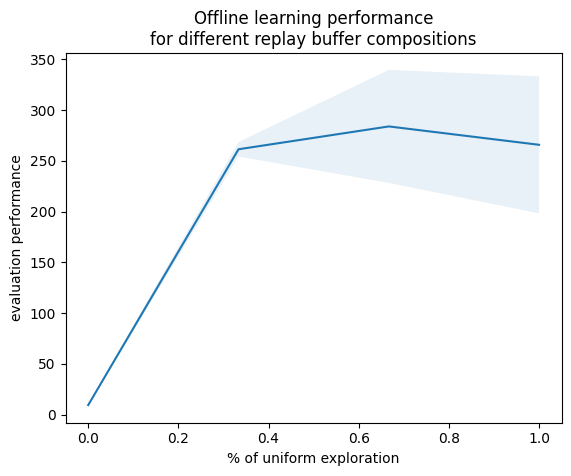

In [12]:
perfs = test_rb_compositions(workspace_unif=workspace_unif, 
                    workspace_best=workspace_best,
                    buffer_size=10000,
                    proportions=np.linspace(0,1,4),
                    agent_constructor=TD3,
                    cfg= cfg_td3_offline,
                    offline_run=run_td3_offline)